1. [EMR (Elastic Map Reduce)](#emr-elastic-map-reduce)
2. [EMR Architecture](#emr-architecture)
3. [EMR Usage](#emr-usage)
4. [EMR - AWS Integration](#emr---aws-integration)
5. [EMR Storage](#emr-storage)
6. [EMR Promises](#emr-promises)
7. [EMR Scaling](#emr-scaling)
8. [Hadoop Introduction](#hadoop-introduction)
10. [EMR Serverless](#emr-serverless)
11. [EMR Serverless Application Lifecycle](#emr-serverless-application-lifecycle)
12. [EMR - Pre-initialized Capacity](#emr---pre-initialized-capacity)
13. [EMR Serverless Security](#emr-serverless-security)
14. [EMR on EKS](#emr-on-eks)

#### EMR (Elastic Map Reduce):
- Managed Hadoop Framework on EC2
    - we can launch a Hadoop cluster on AWS console
    - even though managed, we still need to specify what servers we need, the number of EC2 instance needed on the cluster, etc
- In glue, even though we had Apache Spark cluster running under the hood, we did not have any control. Whereas if we need these low level control then use EMR for it
- supports application such as Spark, HBase, Presto, Flink, Hive, etc
- To develop code on EMR, we use EMR notebook for it
- we have several integration with EMR

#### EMR Architecture:

Master Node:
- manages the cluster
    - tracks status of tasks
    - monitors cluster health
    - Single EC2 instance
    - AKA "Leader node"

Core Node:
- stores HDFS data 
- runs tasks
- can be scaled up and down byt some risk involved
- multi-node cluster have at least one core node

Task Node:
- runs tasks but do not store data
- optional
- no risk of data loss while removing the task nodes
- good use of spot instance

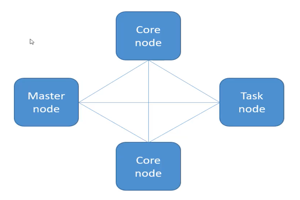

In [3]:
from PIL import Image 
from IPython.display import display

img = Image.open('images/emr.jpeg')
new_image = img.resize((300, 200))
display(new_image)

#### EMR Usage:
Transient vs Long running cluster:
- Transient cluster:
    - these clusters will automatically terminate when all steps are complete
        - Loading data, processing, storing - then shut down
        - saves money
- Long Running cluster:
    - these clusters need to be terminated manually
        - Basically a data warehouse with periodic processing on large datasets
        - can spin up task nodes using spot instances for temporary capacity
        - can use reserved instance for long running clusters to save cost
        - termination protection by default, auto termination off
- we specify the application (eg: Spark) and frameworks at cluster branch
- If we have long running cluster, then we can connect directly to the master node to run the jobs directly by kicking of Spark driver script
- Or, we can submit ordered steps via console to EMR
    - Process data in S3 or HDFS
    - output data to S3 or somewhere else
    - once defined, steps can be invoked via console instead of a command line prompt


#### EMR - AWS Integration:
- EC2 are used used as nodes in EMR (Hadoop cluster)
- VPC to configure virtual network in which we launch the instance 
- S3 is used to store input and output data other than the HDFS
- CloudWatch to monitor the cluster performance and configure alarms
- IAM to provide permissions/access
- CloudTrail to audit request made to EMR service
- DataPipeline to schedule and start cluster

#### EMR Storage:

HDFS:
- Hadoop Distributed File System
- it is Hadoop cluster running on EC2
- multiple copes stored across cluster instances for redundancy
- files stored as blocks (128MB default)
- Ephemeral: HDFS data is lost if we terminate the cluster
- useful for caching intermediate results or workloads with significant random I/O
- process data where it is stored in HDFS

EMRFS: (access S3 as if it was HDFS)
- Elastic Map Reduce File System
- it is EMR cluster running on EC2
- allows persistent storage event after cluster termination
    - S3
- EMRFS Consistent View: 
    - this was setup when we have two concurrent write requests hitting the same file in S3
    - used for S3 consistency
    - it uses DynamoDB under the hood for track consistency
    - may need to tinker with read/write capacity on DynamoDB
- In 2021: S3 has become strongly consistent, hence the use of EMRFS consistent view is not needed anymore

Local File System:
- suitable only for temporary data

EBS:
- allows EMR to be used only on M4 & C4 instance types of EBS
- data will be deleted when cluster is deleted
- EBS volumes can be attached only while launching a cluster
- if we manually detach a EBS volume, EMR treats as a failure and replaces it


#### EMR Promises:
- Pricing: charged by hour + EC2 charges
- provides new node if core node fails
- can add and remove task nodes on the fly
    - increase processing capacity but not HDFS capacity
- can resize running cluster core nodes
    - increase both processing and HDFS capacity
- Core nodes can also be add or removed
    - removing core nodes involves risk at the core node stores data

#### EMR Scaling:

EMR Automatic Scaling:
- Prior to 2020:
    - create custom scaling rules based on CloudWatch metrics
    - supports instance groups only
        - we couldn't mix and max different instance types

EMR Managed Scaling:
- introduced in 2020
    - supports instance groups and instance fleets
    - According to Savings Plan, scales on-demand, spot instances
    - available for Spark, YARN, Hive workloads

- Scale up strategy:
    - first we add core nodes until we hit the core node threshold and then add task nodes until we hit the maximum limit set overall

- Scale down strategy:
    - first we scale down task nodes and then core nodes until the minimum constraint
    - spot instances node are removed first and then the on-demand instance node

#### Hadoop Introduction:
- it comprises of HDFS, YARN, MapReduce which combines to form the Hadoop core or common

MapReduce:
- made up of mappers and reducers
    - map function will map data to sets of key-value pairs i.e. intermediate results from processing
    - reducer function will combine the intermediate result and apply algorithms to them and produces the final result
- it is used for distributed data processing 
- Largely supplanted by Spark these days
- reliable and fault tolerant

YARN:
- it is Yet Another Resource Negotiator
- manages cluster resources for multiple data processing frameworks

HDFS:
- it is a Hadoop distributed file system
- distributes data blocks across cluster in a redundant manner
- Ephemeral in EMR: data is lost when clusters are terminated
- useful for caching intermediate results while data processing via MapReduce or workloads with significant random I/O

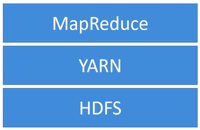

In [5]:
from PIL import Image 
from IPython.display import display

img = Image.open('images/hdfs.jpeg')
new_image = img.resize((200, 130))
display(new_image)

#### EMR Serverless:
- New feature in EMR, it is the same as EMR before except we do not define the capacity instead AWS provides it automatically
- Just choose EMR Release and Runtime (Spark, Hive, Presto)
- Submit queries/request via Job run request
    - here we do not run the job directly in the master node and instead, we store the script in an S3 location and feed the S3 path with the EMR cluster to run the job indirectly
- However, EMR can still manage the capacity
    - specify worker size and pre-initialized capacity
        - "worker" refers to a virtual machine within an EMR cluster
    - Even if we pre-initialize the capacity, the EMR will access the capacity need for the job and will scale up or down 
    - EMR cluster will be withing one Region across all AZs

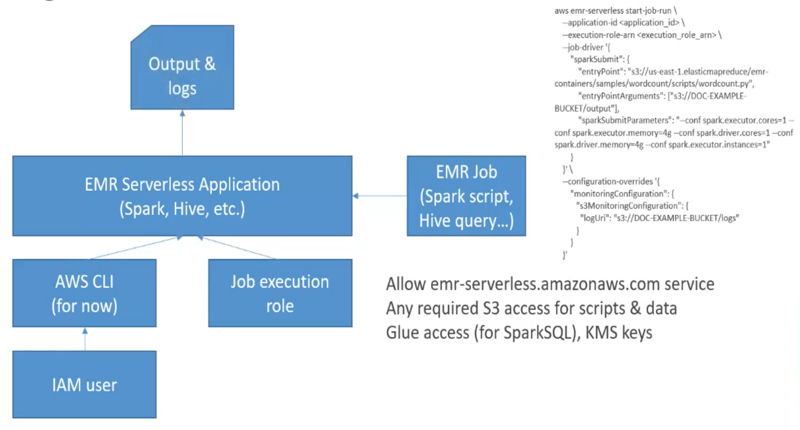

In [8]:
from PIL import Image 
from IPython.display import display

img = Image.open('images/emrserverless.jpeg')
new_image = img.resize((800, 430))
display(new_image)

The above Process:
- We need an IAM user first to run AWS CLI command to create the EMR serverless cluster
- For the EMr serverless cluster to be created, we need Job execution role
- Now using the Job execution role + AWS CLI command from an IAM user can create EMR serverless application
- Into the EMR serverless application, we can run EMR job by feeding Spark Script, Hive Query, etc
    - the EMR job can contain managing the EMR capacity, instances, number of nodes, etc

#### EMR Serverless Application Lifecycle:
- Even though EMr serverless manages the capacity automatically but it does work fully automatic
    - We need to create the application via CreateApplication API, 
    - start the application via StartApplication API, 
    - stop the application via StopApplication API, 
    - delete the application via DeleteApplication API (to avoid additional charges)
- Since we create EMR serverless application via CLI
    - if the EMR application is created successfully, then we can go to starting the application. If the application is not created successfully then it will terminated
    - After creating the application, we can manually terminate the application if needed
    - if the application is started successfully then we can go to stopping the application after performing the operation. Or if the application fails to start then it will go to stopping the application
    - Once the application has successfully started and stopped, we can re-run it again or terminate it 

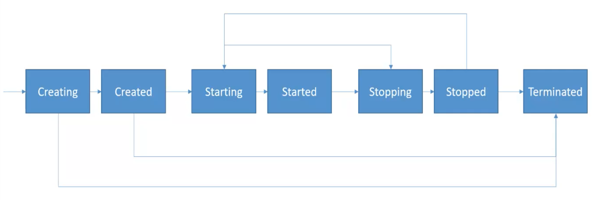

In [13]:
from PIL import Image 
from IPython.display import display

img = Image.open('images/emrserverlesslifecycle.jpeg')
new_image = img.resize((600, 200))
display(new_image)

#### EMR - Pre-initialized Capacity:
- Spark add 10% overhead to memory requested for drivers and executors
- Make sure, we have 10% more capacity than the initial capacity required for the job
    - Eg: shown below

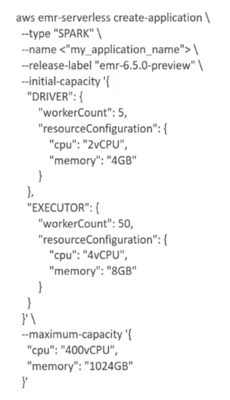

In [17]:
from PIL import Image 
from IPython.display import display

img = Image.open('images/intialcapacity.jpeg')
new_image = img.resize((230, 400))
display(new_image)

#### EMR Serverless Security:
- Same as EMR
- EMRFS (S3):
    - At rest: KMS encryption, S3 managed keys, Client-side encryption
    - In flight:TLS
- local disk encryption
- spark communication between drivers and executors is encrypted
- hive communication between Glue Hive metastore and EMR uses TLS
- forces HTTPS(TLS) on S3 policies with aws:SecureTransport 

#### EMR on EKS:
- allows submitting spark job on EKS without provisioning clusters
    - better than having a standalone Spark cluster, running spark job on EKS provides us the option to use EKS service features
- fully managed
- share resources between spark and other applications running on Kubernetes

Process:
- With few clicks on AWS console, we can choose the apache spark version we want
    - deploy EMR workload to EKS by EMR automatically packaging the workload into a container
    - provides pre-built connectors for integrating with other AWS resources

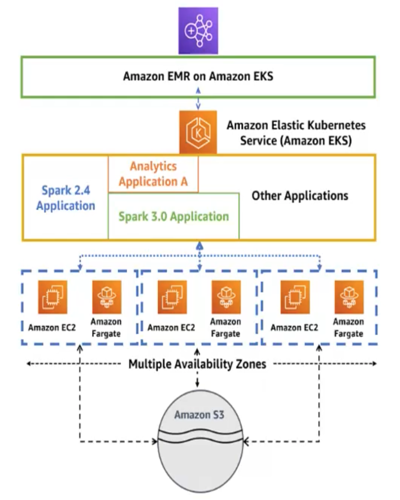

In [19]:
from PIL import Image 
from IPython.display import display

img = Image.open('images/EKS.jpeg')
new_image = img.resize((400, 500))
display(new_image)